In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
# TensorFlow 2.0.0 is required for this code to work.
# Uncomment and run the following line to install the CPU version.
# !pip install tensorflow==2.0.0-beta0 --ignore-installed

### Import necessary modules:

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from random import shuffle
import tensorflow as tf
from tensorflow.keras.applications import MobileNetV2
from pyspark.sql import SparkSession
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.recommendation import ALS, ALSModel
from sklearn.model_selection import train_test_split
from functools import reduce
from functions import prepare_image, extract_features
import os
import json
from PIL import Image

### Get a list of all hashtags

In [4]:
json_file_names = os.listdir('json_files')
# Remove the 5 char .json file ending to isolate hashtag name
hashtags = [hashtag[:-5] for hashtag in json_file_names]

In [5]:
# remove '.DS_', '.ipynb_checkp'
non_hashtags = ['.DS_', '.ipynb_checkp']
for non_hashtag in non_hashtags:
    try:
        hashtags.remove(non_hashtag)
    except:
        pass # If we can't remove it, it's already gone
    
hashtags

['fitness',
 'selfie',
 'travel',
 'nature',
 'babies',
 'cars',
 'food',
 'architecture',
 'animals',
 'wedding']

In [6]:
hashtag_dfs = []
for hashtag in hashtags: 
    hashtag_dfs.append(pd.read_json(f'json_files/{hashtag}.json'))
df = reduce(lambda x, y: pd.concat([x, y]), hashtag_dfs)

In [7]:
full_list = pd.DataFrame.reset_index(df, drop=True)

In [8]:
full_list.tail()

,hashtags,image,image_local_name,post_link,search_hashtag
2995,"[#Wedding, #ido, #ianandwendytietheknot, #wedd...",https://scontent-sea1-1.cdninstagram.com/vp/29...,905a1d9c-b29d-44c7-ab5c-408c0b5d91ac.jpg,https://www.instagram.com/p/B0dcq0FBPQ3/,wedding
2996,"[#wedding, #mariages, #celebrantecuritiba, #ce...",https://scontent-sea1-1.cdninstagram.com/vp/bb...,6e424f02-d10e-42db-a233-9ce2724fb8a9.jpg,https://www.instagram.com/p/BwXbu7MgCTZ/,wedding
2997,"[#weddingring, #wedding, #shoes, #nancy, #sigm...",https://scontent-sea1-1.cdninstagram.com/vp/25...,ae49d2bb-95f7-4d16-9ee5-1603e97e6dd8.jpg,https://www.instagram.com/p/B0gwuc2icKv/,wedding
2998,"[#wedding, #standesamtgoetheallee, #retroweddi...",https://scontent-sea1-1.cdninstagram.com/vp/21...,9152a6d4-abda-4adf-87a4-7988dc4bb3ac.jpg,https://www.instagram.com/p/B0gwufzImAz/,wedding
2999,"[#kinalik, #gelinlik, #bursad, #wedding, #dama...",https://scontent-sea1-1.cdninstagram.com/vp/15...,09aaa471-2ed6-4ead-84db-e4aa6b0ece8f.jpg,https://www.instagram.com/p/B0gwubDhu6M/,wedding


### Resizing image to be used in tensorflow framework for Deep Feature Extraction

In [9]:
pics = []
for i, row in full_list.iterrows():
    name = row['image_local_name']
    hashtag = row['search_hashtag']
    img_path = f'data/{hashtag}/{name}'
    try:
        img = prepare_image(img_path, where='local')
        pics.append({'pic': img, 'hashtag': hashtag, 'name': name})
    except:
        # If a file in the list isn't in 
        # storage, skip it and continue
        pass

In [10]:
type(pics[64]['pic'])

tensorflow.python.framework.ops.EagerTensor

W0829 16:53:37.199170 4554425792 image.py:656] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


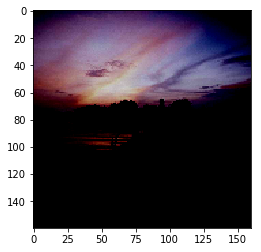

In [11]:
plt.imshow(pics[64]['pic']);

In [12]:
# add extracted deep features information to pics, make it a list of dictionaries

deep_features = list(map(extract_features, pics))

In [13]:
# confirm that the type of deep_features variable is a list

type(deep_features)

list

In [14]:
# train test split deep features: not used in the model, just in case needs to be used in the future

shuffle(deep_features)
train_size = int(len(deep_features) * .7)
train, test = deep_features[:train_size], deep_features[train_size:]

In [18]:
# check the first element of the train set
pic = train[0]
pic.keys()

dict_keys(['pic', 'hashtag', 'name', 'deep_features'])

W0829 16:57:54.694450 4554425792 image.py:656] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


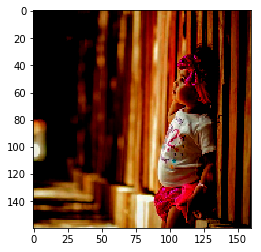

In [28]:
plt.imshow(pic['pic']);

In [24]:
pic['hashtag'], pic['deep_features'].shape, pic['pic'].shape

('babies', (1280,), TensorShape([160, 160, 3]))

In [25]:
df = pd.DataFrame(deep_features)

In [26]:
df.head()

,deep_features,hashtag,name,pic
0,"[0.6533674, 1.4187746, 0.0, 0.06313879, 2.2593...",babies,cafbd18c-edea-4106-8b1d-47155a225e96.jpg,"(((tf.Tensor(-0.6960784, shape=(), dtype=float..."
1,"[0.00040296555, 0.9536936, 0.0, 0.044731237, 0...",animals,fce4c729-0a47-4647-8708-e9130cea62c5.jpg,"(((tf.Tensor(0.6313726, shape=(), dtype=float3..."
2,"[0.114939824, 1.1331617, 0.08020685, 0.0, 0.24...",babies,7a456b37-3ec0-4e99-9146-9aba8509a4ab.jpg,"(((tf.Tensor(0.49803925, shape=(), dtype=float..."
3,"[0.6306964, 0.04989948, 0.53576744, 0.04323692...",animals,5692936c-aaeb-413c-97e0-a8b1621d44a7.jpg,"(((tf.Tensor(-0.10196076, shape=(), dtype=floa..."
4,"[1.8075038, 0.028879395, 0.0, 0.3726905, 0.754...",food,d81b1b60-f199-4860-a66d-70a0d8ec4d32.jpg,"(((tf.Tensor(0.96862745, shape=(), dtype=float..."


In [27]:
filepath = "pkl_files/df_deep_features.pkl"
if os.path.exists(filepath):
    df.to_pickle(filepath)

## ALS Model

In [30]:
spark = SparkSession.builder.master('local').getOrCreate()

In [35]:
# Train test split full_list. Not used in the model. Use code when necessary.
train, test = train_test_split(full_list, test_size=0.2)

len(train), len(test), len(full_list)

(2400, 600, 3000)

In [32]:
train.head()

,hashtags,image,image_local_name,post_link,search_hashtag
449,[],https://scontent-sea1-1.cdninstagram.com/vp/a9...,ef53c407-528c-4c5e-9612-05edf93ec15a.jpg,https://www.instagram.com/p/B0hGkQGgiKU/,selfie
2976,"[#wedding, #etsy, #vintageglam, #vintageforsal...",https://scontent-sea1-1.cdninstagram.com/vp/b5...,37263c6a-5a19-4eb7-8ec7-c570e5dbeee0.jpg,https://www.instagram.com/p/B0gwp4ig5EP/,wedding
1290,[babies],NaN,ac2cf585-3a14-4487-b82a-ccfebc79e3e1.jpg,NaN,babies
1534,"[#mercedes, #streetking, #bwm, #supercars, #ra...",https://scontent-sea1-1.cdninstagram.com/vp/ca...,16a042b8-71a6-41d2-a825-c990e0332d1c.jpg,https://www.instagram.com/p/B0hQ4yBBdvJ/,cars
853,"[#instarecuerdos, #travelphotograpy, #moments,...",https://scontent-lga3-1.cdninstagram.com/vp/02...,568dd683-8161-447b-9f04-3d76a7e42a7e.jpg,https://www.instagram.com/p/By3OEmHHqzG/,travel


In [34]:
full_list.head()

,hashtags,image,image_local_name,post_link,search_hashtag
0,"[#herbalifeshake, #kilokontrol, #herbalife, #h...",https://scontent-mad1-1.cdninstagram.com/vp/bd...,ff07fa3f-0482-4757-926e-3e6229f7d0d7.jpg,https://www.instagram.com/p/B02xq0AFpe9/,fitness
1,[],https://scontent-mad1-1.cdninstagram.com/vp/b9...,7cff7c70-b983-4c6b-adee-fc5676acddf3.jpg,https://www.instagram.com/p/B02sMkwJnny/,fitness
2,"[#bollywood, #indian, #art, #love, #india, #gi...",https://scontent-mad1-1.cdninstagram.com/vp/2b...,b7de6dac-4294-45d5-aac0-8a749b7e4cc5.jpg,https://www.instagram.com/p/B02zfuaDfP4/,fitness
3,"[#popxodaily, #personalblog, #loveforblack, #l...",https://scontent-mad1-1.cdninstagram.com/vp/34...,f699faef-b071-46f2-bf5c-fd9f1ff7626a.jpg,https://www.instagram.com/p/B02yOH3nfzB/,fitness
4,[],https://scontent-mad1-1.cdninstagram.com/vp/31...,7f25fd41-5f1b-4181-8128-4f7464f4c2ad.jpg,https://www.instagram.com/p/B02rDHDF28T/,fitness


In [36]:
full_list['clean_hashtags'] = full_list['hashtags'].apply(
    lambda hashtag_list: [h for h in hashtag_list if h.startswith('#')])

In [37]:
full_list.head()

,hashtags,image,image_local_name,post_link,search_hashtag,clean_hashtags
0,"[#herbalifeshake, #kilokontrol, #herbalife, #h...",https://scontent-mad1-1.cdninstagram.com/vp/bd...,ff07fa3f-0482-4757-926e-3e6229f7d0d7.jpg,https://www.instagram.com/p/B02xq0AFpe9/,fitness,"[#herbalifeshake, #kilokontrol, #herbalife, #h..."
1,[],https://scontent-mad1-1.cdninstagram.com/vp/b9...,7cff7c70-b983-4c6b-adee-fc5676acddf3.jpg,https://www.instagram.com/p/B02sMkwJnny/,fitness,[]
2,"[#bollywood, #indian, #art, #love, #india, #gi...",https://scontent-mad1-1.cdninstagram.com/vp/2b...,b7de6dac-4294-45d5-aac0-8a749b7e4cc5.jpg,https://www.instagram.com/p/B02zfuaDfP4/,fitness,"[#bollywood, #indian, #art, #love, #india, #gi..."
3,"[#popxodaily, #personalblog, #loveforblack, #l...",https://scontent-mad1-1.cdninstagram.com/vp/34...,f699faef-b071-46f2-bf5c-fd9f1ff7626a.jpg,https://www.instagram.com/p/B02yOH3nfzB/,fitness,"[#popxodaily, #personalblog, #loveforblack, #l..."
4,[],https://scontent-mad1-1.cdninstagram.com/vp/31...,7f25fd41-5f1b-4181-8128-4f7464f4c2ad.jpg,https://www.instagram.com/p/B02rDHDF28T/,fitness,[]


In [38]:
image_lookup = dict(zip(full_list['image_local_name'], full_list.index))

In [39]:
all_hashtags = set()
for tags in full_list['clean_hashtags']:
    all_hashtags.update(tags)
hashtag_lookup = {hashtag: i for i, hashtag in enumerate(all_hashtags)}

In [40]:
hashtag_data = []
for i in full_list.index:
    hashtags = full_list.loc[i, 'clean_hashtags']
    for hashtag in hashtags:
        hashtag_data.append(
            {'image_id': i,
             'hashtag_id': hashtag_lookup[hashtag],
             'rating': 1}
        )
hashtag_df_long = pd.DataFrame(hashtag_data)

In [41]:
hashtag_df_long.tail()

,hashtag_id,image_id,rating
47467,13214,2999,1
47468,4956,2999,1
47469,4027,2999,1
47470,10732,2999,1
47471,9057,2999,1


In [42]:
full_list.dtypes

hashtags            object
image               object
image_local_name    object
post_link           object
search_hashtag      object
clean_hashtags      object
dtype: object

In [43]:
als = ALS(userCol='image_id',
          itemCol='hashtag_id',
          implicitPrefs=True,
          alpha=40)

In [44]:
hashtag_spark_df = spark.createDataFrame(hashtag_df_long)

In [45]:
als_model = als.fit(hashtag_spark_df)

In [46]:
als_model.write().overwrite().save('als')

In [47]:
#load the model
#ALSModel model = ALSModel.load(“/path/to/read/the/model/from”)

In [51]:
recs = als_model.recommendForAllUsers(numItems=10).toPandas()
len(recs)

2261

In [50]:
hashtag_index = list(all_hashtags)

In [ ]:
def lookup_hashtag(hashtag_id):
    return hashtag_index[hashtag_id]

In [ ]:
def lookup_hashtag_recs(rec_scores):
    return [lookup_hashtag(rec) for (rec, score) in rec_scores]

In [ ]:
recs['recommended_hashtags'] = recs['recommendations'].apply(lookup_hashtag_recs)

In [ ]:
recs.index = recs['image_id']

In [ ]:
compare_recs = recs.join(full_list, how='left')[['recommendations',
                                                 'recommended_hashtags',
                                                 'hashtags',
                                                 'image_local_name',
                                                 'search_hashtag']]

In [ ]:
compare_recs.loc[0, 'image_local_name']

In [ ]:
compare_recs.to_pickle('pkl_files/recs.pkl')
compare_recs.drop('recommendations', axis=1)
image_factors = als_model.userFactors.toPandas()
image_factors.index = image_factors['id']
compare_recs.join(image_factors);

### Pickle hashtag data

In [ ]:
len(hashtag_lookup), type(hashtag_lookup)

In [ ]:
hashtags_df = pd.DataFrame.from_dict(hashtag_lookup, orient='index')
hashtags_df.head()

In [ ]:
hashtags_df = hashtags_df.reset_index()
hashtags_df.columns = ['hashtag', 'id']

In [ ]:
hashtags_df.index = hashtags_df['id']

In [ ]:
hashtags_df = hashtags_df.drop('id', axis=1)

In [ ]:
hashtags_df.head()

In [ ]:
hashtags_df.to_pickle("pkl_files/hashtags_df.pkl")